In [61]:
import glob
import shutil
from tqdm.notebook import tqdm
import random
import pandas as pd
import numpy as np


# converting to yolo annotation
import xml.etree.ElementTree as ET
import os
import json


def xml_to_yolo(bbox, w, h):
    # xmin, ymin, xmax, ymax
    x_center = ((bbox[2] + bbox[0]) / 2) / w
    y_center = ((bbox[3] + bbox[1]) / 2) / h
    width = (bbox[2] - bbox[0]) / w
    height = (bbox[3] - bbox[1]) / h
    return [x_center, y_center, width, height]

In [62]:
with open('paths.txt', 'r') as f:
    paths = [path.strip() for path in f.readlines()]

annot_list = []

for path in paths:
    path = f'{path}/train'
    ## Finding all the images and separating in training and validation
    annot_list += glob.glob(f'{path}/annotations/xmls/*.xml')


In [63]:
data = {'labels': annot_list, 'images': []}

classes = []

for idx, file in enumerate(annot_list):

    basename = os.path.basename(file)
    filename = os.path.splitext(basename)[0]

    # check if the label contains the corresponding image file

    image_dir = '/'.join(file.split('/')[:4])+'/images'
    image_file = os.path.join(image_dir, filename+'.jpg')
    data['images'].append(image_file)
    
    if not os.path.exists(image_file):
        print(filename, 'image does not exist!')
        continue
        
    # parse the content of the xml file
    tree = ET.parse(annot_list[idx])
    root = tree.getroot()
    width = int(root.find("size").find("width").text)
    height = int(root.find("size").find("height").text)

    for obj in root.findall('object'):
        label = obj.find("name").text
        # check for new classes and append to list
        if label not in classes:
            classes.append(label)
            data[label] = np.zeros(len(annot_list), dtype=int)
        data[label][idx] += 1
        
        
df = pd.DataFrame(data)
df = df.sample(frac=1).reset_index(drop=True)

df

,labels,images,D10,D40,D00,Repair,D20,Block crack,D44,D43,D11,D01,D50,D0w0
0,./RDD2022_all_countries/India/train/annotation...,./RDD2022_all_countries/India/train/images/Ind...,0,1,0,0,0,0,0,0,0,0,0,0
1,./RDD2022_all_countries/China_MotorBike/train/...,./RDD2022_all_countries/China_MotorBike/train/...,2,0,4,1,0,0,0,0,0,0,0,0
2,./RDD2022_all_countries/Czech/train/annotation...,./RDD2022_all_countries/Czech/train/images/Cze...,0,0,0,0,0,0,0,0,0,0,0,0
3,./RDD2022_all_countries/Japan/train/annotation...,./RDD2022_all_countries/Japan/train/images/Jap...,1,0,0,0,1,0,0,0,0,0,0,0
4,./RDD2022_all_countries/United_States/train/an...,./RDD2022_all_countries/United_States/train/im...,2,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30219,./RDD2022_all_countries/India/train/annotation...,./RDD2022_all_countries/India/train/images/Ind...,0,4,0,0,0,0,0,0,0,0,0,0
30220,./RDD2022_all_countries/Japan/train/annotation...,./RDD2022_all_countries/Japan/train/images/Jap...,1,0,0,0,2,0,0,0,0,0,0,0
30221,./RDD2022_all_countries/Czech/train/annotation...,./RDD2022_all_countries/Czech/train/images/Cze...,0,0,0,0,0,0,0,0,0,0,0,0
30222,./RDD2022_all_countries/Japan/train/annotation...,./RDD2022_all_countries/Japan/train/images/Jap...,0,0,0,0,0,0,0,1,0,0,0,0


In [64]:
def plot_data(df):
    frequencies = df.mean(axis=0).sort_values()

    _ = frequencies.plot(title='Dataset for analyzing cracks', 
                         kind='barh', 
                         figsize=(12, 12),
                         color='#479EF8')

,labels,images,D10,D40,D00,Repair,D20,Block crack,D44,D43,D11,D01,D50,D0w0
0,./RDD2022_all_countries/India/train/annotation...,./RDD2022_all_countries/India/train/images/Ind...,0,1,0,0,0,0,0,0,0,0,0,0
1,./RDD2022_all_countries/China_MotorBike/train/...,./RDD2022_all_countries/China_MotorBike/train/...,2,0,4,1,0,0,0,0,0,0,0,0
2,./RDD2022_all_countries/Czech/train/annotation...,./RDD2022_all_countries/Czech/train/images/Cze...,0,0,0,0,0,0,0,0,0,0,0,0
3,./RDD2022_all_countries/Japan/train/annotation...,./RDD2022_all_countries/Japan/train/images/Jap...,1,0,0,0,1,0,0,0,0,0,0,0
4,./RDD2022_all_countries/United_States/train/an...,./RDD2022_all_countries/United_States/train/im...,2,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30219,./RDD2022_all_countries/India/train/annotation...,./RDD2022_all_countries/India/train/images/Ind...,0,4,0,0,0,0,0,0,0,0,0,0
30220,./RDD2022_all_countries/Japan/train/annotation...,./RDD2022_all_countries/Japan/train/images/Jap...,1,0,0,0,2,0,0,0,0,0,0,0
30221,./RDD2022_all_countries/Czech/train/annotation...,./RDD2022_all_countries/Czech/train/images/Cze...,0,0,0,0,0,0,0,0,0,0,0,0
30222,./RDD2022_all_countries/Japan/train/annotation...,./RDD2022_all_countries/Japan/train/images/Jap...,0,0,0,0,0,0,0,1,0,0,0,0


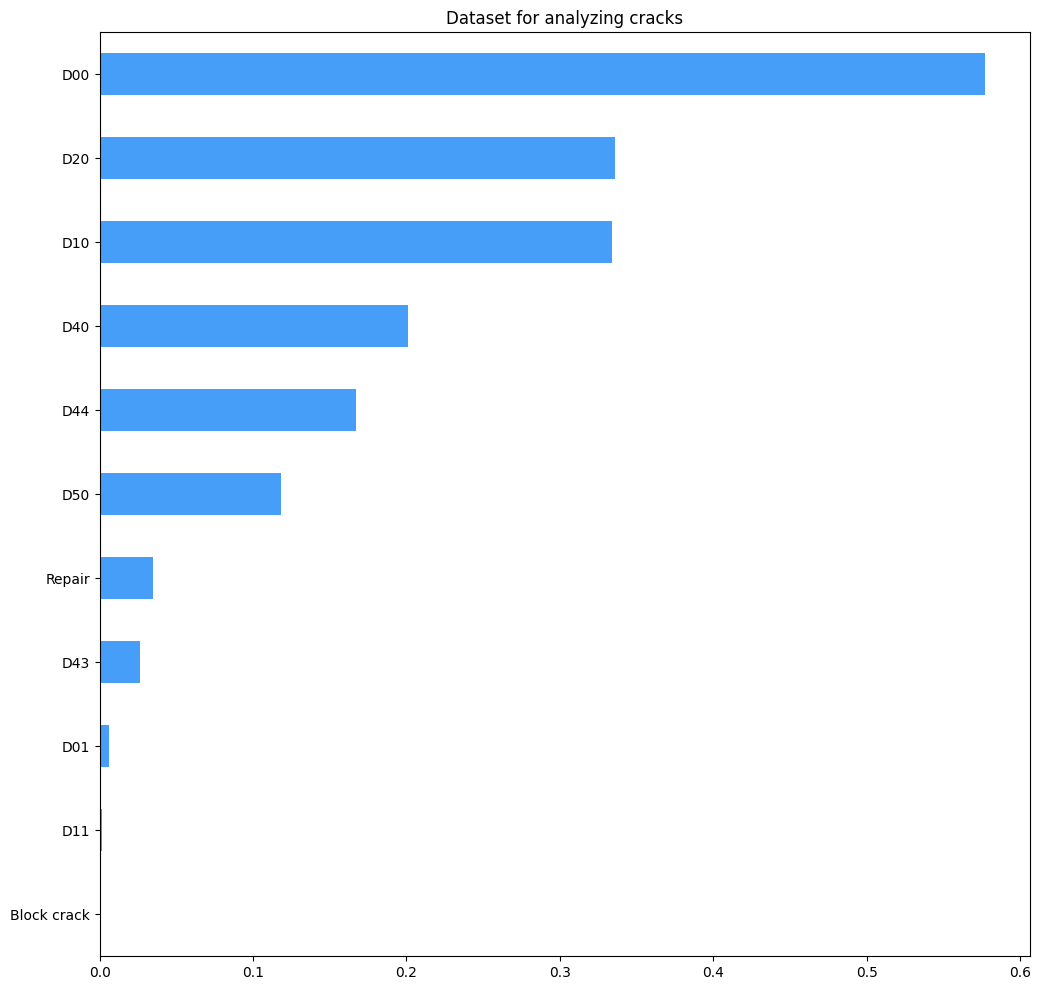

In [65]:
plot_data(df.iloc[:, 2:-1])

df

In [66]:
classes_to_drop = ['D0w0', 'Block crack', 'D11', 'D01', 'D43', 'Repair']

df.drop(classes_to_drop, axis=1, inplace=True)

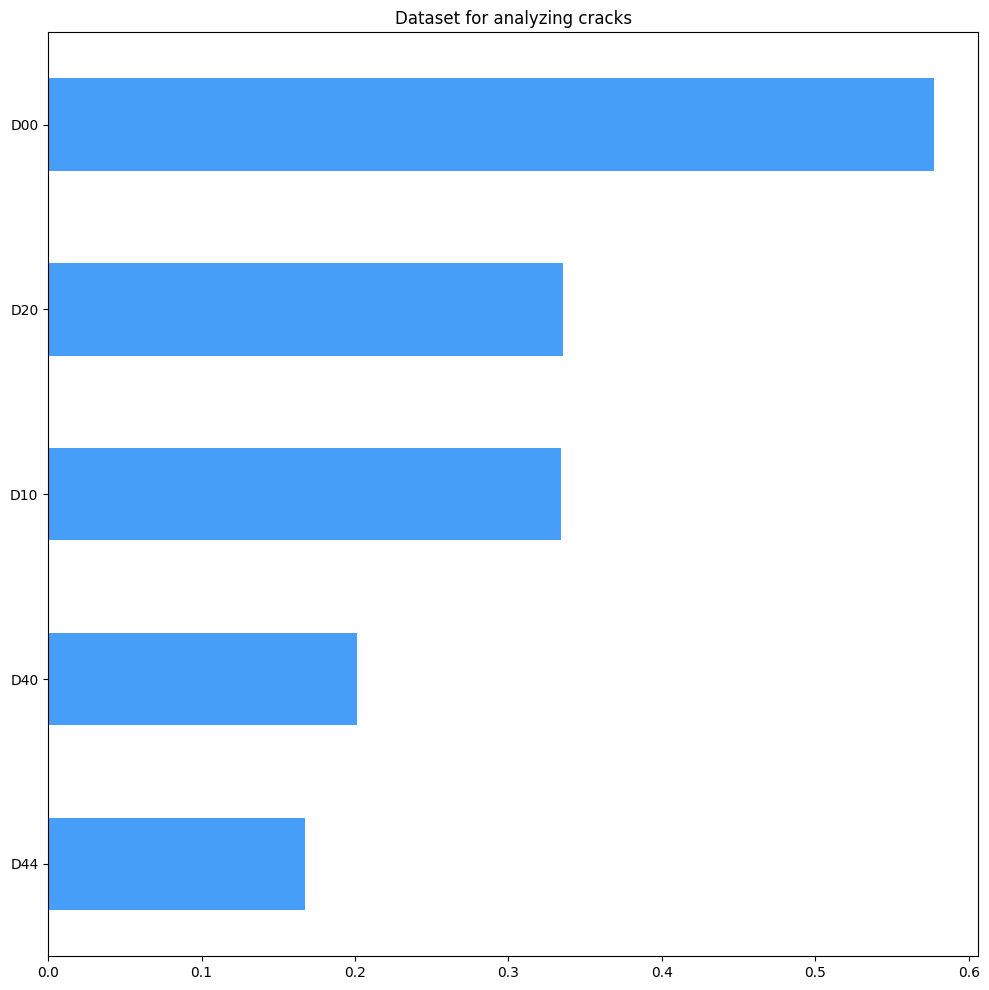

In [67]:
plot_data(df.iloc[:, 2:-1])

In [68]:
new_classes = [elem for elem in classes if elem not in classes_to_drop]
print(new_classes)

trim_df = df.loc[(df['D00'] == df[new_classes].sum(axis=1)) & (df['D00'] > 0)]

print("Shape of original dataframe:", df.shape)
#Prints shape of dataframe containing all rows where D00 exclusively is 0
print("Trimmer dataframe:", trim_df.shape)
print("Number of D00 cracks detected:", df['D00'].sum())
print("Number of D10 cracks detected:", df['D10'].sum())

['D10', 'D40', 'D00', 'D20', 'D44', 'D50']
Shape of original dataframe: (30224, 8)
Trimmer dataframe: (4998, 8)
Number of D00 cracks detected: 17446
Number of D10 cracks detected: 10100


In [69]:
trim_df = trim_df.sort_values(by=['D00'], ascending=False)
trim_df = trim_df.iloc[:3600, :]
print("Number of D00 detections in trimmer_df:", trim_df['D00'].sum())


trim_df

Number of D00 detections in trimmer_df: 6327


,labels,images,D10,D40,D00,D20,D44,D50
25081,./RDD2022_all_countries/India/train/annotation...,./RDD2022_all_countries/India/train/images/Ind...,0,0,7,0,0,0
23860,./RDD2022_all_countries/United_States/train/an...,./RDD2022_all_countries/United_States/train/im...,0,0,7,0,0,0
2250,./RDD2022_all_countries/China_MotorBike/train/...,./RDD2022_all_countries/China_MotorBike/train/...,0,0,7,0,0,0
26132,./RDD2022_all_countries/United_States/train/an...,./RDD2022_all_countries/United_States/train/im...,0,0,7,0,0,0
2737,./RDD2022_all_countries/China_MotorBike/train/...,./RDD2022_all_countries/China_MotorBike/train/...,0,0,7,0,0,0
...,...,...,...,...,...,...,...,...
1428,./RDD2022_all_countries/United_States/train/an...,./RDD2022_all_countries/United_States/train/im...,0,0,1,0,0,0
1434,./RDD2022_all_countries/Czech/train/annotation...,./RDD2022_all_countries/Czech/train/images/Cze...,0,0,1,0,0,0
1454,./RDD2022_all_countries/Czech/train/annotation...,./RDD2022_all_countries/Czech/train/images/Cze...,0,0,1,0,0,0
1457,./RDD2022_all_countries/China_MotorBike/train/...,./RDD2022_all_countries/China_MotorBike/train/...,0,0,1,0,0,0


In [70]:
cond = df['labels'].isin(trim_df['labels'])
df.drop(df[cond].index, inplace = True)

df.reset_index(drop=True, inplace=True)

print(df.shape)

(26624, 8)


Number of D00 detections after processing: 11119


/var/folders/k6/t__53lhj7j59kljh21yj7r8m0000gn/T/ipykernel_35137/293938576.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  frequencies = df.mean(axis=0).sort_values()


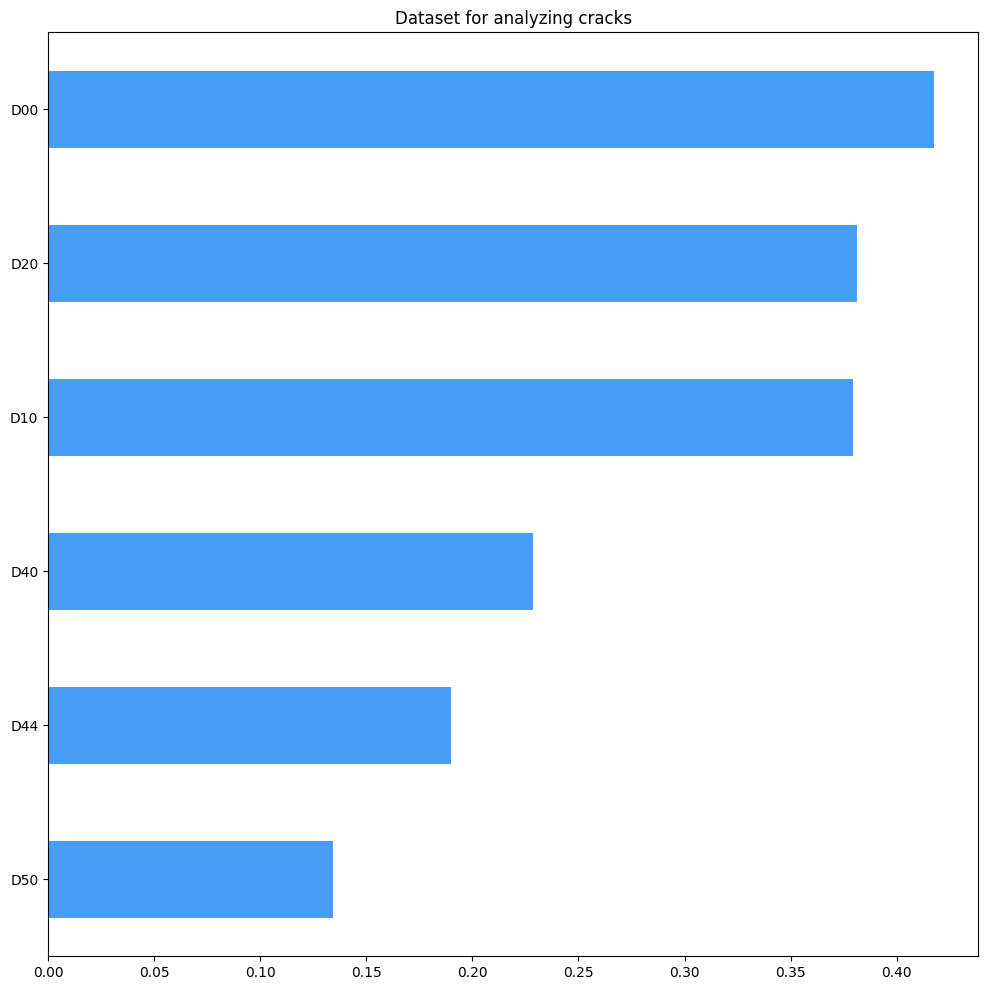

In [71]:
plot_data(df[2:-1])

print("Number of D00 detections after processing:", df['D00'].sum())

In [29]:
#Removing rows where there are no detectinos
df = df.loc[df[new_classes].sum(axis=1) != 0]
df.reset_index(drop=True, inplace=True)
print("Shape of dataframe after removing 'zero rows'", df.shape)

Shape of dataframe after removing 'zero rows' (19203, 8)


In [30]:
import numpy as np

split_data = []

for idx, row in tqdm(df.iterrows()):
    if idx <= df.shape[0]*0.75:
        split_data.append('train')
    else:
        split_data.append('val')

        
df['split'] = split_data

df.reset_index(drop=True, inplace=True)

0it [00:00, ?it/s]

/var/folders/k6/t__53lhj7j59kljh21yj7r8m0000gn/T/ipykernel_31980/702724433.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['split'] = split_data


In [31]:
df.to_csv('training_data.csv')

df

,labels,images,D10,D40,D00,D20,D44,D50,split
0,./RDD2022_all_countries/Japan/train/annotation...,./RDD2022_all_countries/Japan/train/images/Jap...,0,0,0,0,1,0,train
1,./RDD2022_all_countries/Japan/train/annotation...,./RDD2022_all_countries/Japan/train/images/Jap...,1,0,0,2,1,0,train
2,./RDD2022_all_countries/Japan/train/annotation...,./RDD2022_all_countries/Japan/train/images/Jap...,0,0,0,0,1,0,train
3,./RDD2022_all_countries/Japan/train/annotation...,./RDD2022_all_countries/Japan/train/images/Jap...,0,0,0,1,0,0,train
4,./RDD2022_all_countries/Japan/train/annotation...,./RDD2022_all_countries/Japan/train/images/Jap...,1,0,2,0,1,0,train
...,...,...,...,...,...,...,...,...,...
19198,./RDD2022_all_countries/Japan/train/annotation...,./RDD2022_all_countries/Japan/train/images/Jap...,0,0,0,0,1,0,val
19199,./RDD2022_all_countries/China_MotorBike/train/...,./RDD2022_all_countries/China_MotorBike/train/...,2,1,2,1,0,0,val
19200,./RDD2022_all_countries/India/train/annotation...,./RDD2022_all_countries/India/train/images/Ind...,0,0,0,1,0,0,val
19201,./RDD2022_all_countries/Japan/train/annotation...,./RDD2022_all_countries/Japan/train/images/Jap...,0,0,0,0,1,0,val


In [32]:
os.makedirs('./dataset/train/images')
os.makedirs('./dataset/train/labels')
os.makedirs('./dataset/val/images')
os.makedirs('./dataset/val/labels')

In [33]:
for idx, row in tqdm(df.iterrows()):
    
    annotation = row['labels']
    image = row['images']
    
    result = []

    # parse the content of the xml file
    tree = ET.parse(annotation)
    root = tree.getroot()
    width = int(root.find("size").find("width").text)
    height = int(root.find("size").find("height").text)

    for obj in root.findall('object'):
        label = obj.find("name").text
        if label in classes_to_drop:
            continue
        index = new_classes.index(label)
        pil_bbox = [int(float(x.text)) for x in obj.find("bndbox")]
        yolo_bbox = xml_to_yolo(pil_bbox, width, height)
        # convert data to string
        bbox_string = " ".join([str(x) for x in yolo_bbox])
        result.append(f"{index} {bbox_string}")
        

    if result:
        
        if row['split'] == 'train':
            dest = 'dataset/train'
        else:
            dest = 'dataset/val'
        
        
        # generate a YOLO format text file for each xml file
        with open(dest+'/labels/'+str(idx).zfill(6)+'.txt', 'w') as f:
            f.write('\n'.join(result))
            
        # moving images
        shutil.copy(
            image,
            dest+'/images/'+str(idx).zfill(6)+'.jpg'
        )
        
# generate the classes file as reference
with open('classes.txt', 'w', encoding='utf8') as f:
    f.write(json.dumps(new_classes))

0it [00:00, ?it/s]

In [34]:
import cv2
import matplotlib.pyplot as plt

def plot_bounding_box(image_path):
    img = cv2.imread(image_path)
    dh, dw, _ = img.shape

    split_string = image_path.split('/')
    

    
    label_path = '/'.join((split_string[:2]))+'/labels/'+split_string[3].split('.')[0]+'.txt'
    fl = open(label_path, 'r')
    data = fl.readlines()
    fl.close()

    for dt in data:

        # Split string to float
        _, x, y, w, h = map(float, dt.split(' '))

        # Taken from https://github.com/pjreddie/darknet/blob/810d7f797bdb2f021dbe65d2524c2ff6b8ab5c8b/src/image.c#L283-L291
        # via https://stackoverflow.com/questions/44544471/how-to-get-the-coordinates-of-the-bounding-box-in-yolo-object-detection#comment102178409_44592380
        l = int((x - w / 2) * dw)
        r = int((x + w / 2) * dw)
        t = int((y - h / 2) * dh)
        b = int((y + h / 2) * dh)

        if l < 0:
            l = 0
        if r > dw - 1:
            r = dw - 1
        if t < 0:
            t = 0
        if b > dh - 1:
            b = dh - 1

        cv2.rectangle(img, (l, t), (r, b), (0, 0, 255), 1)

    plt.imshow(img)
    plt.show()



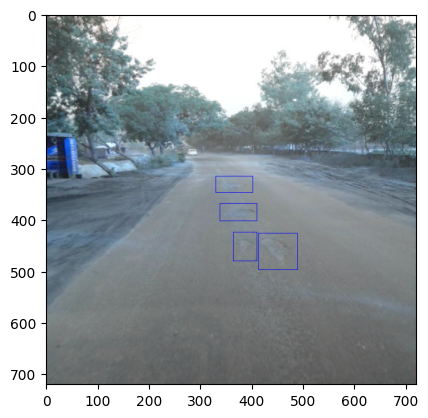

In [38]:
plot_bounding_box('dataset/train/images/000015.jpg')

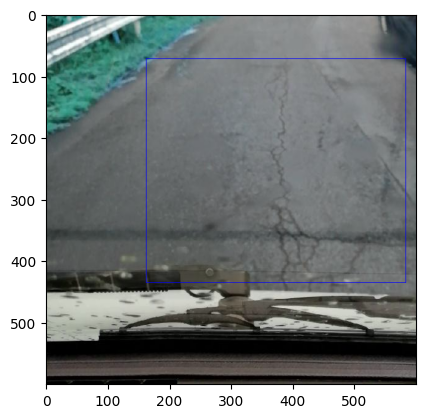

In [36]:
plot_bounding_box('dataset/train/images/000028.jpg')

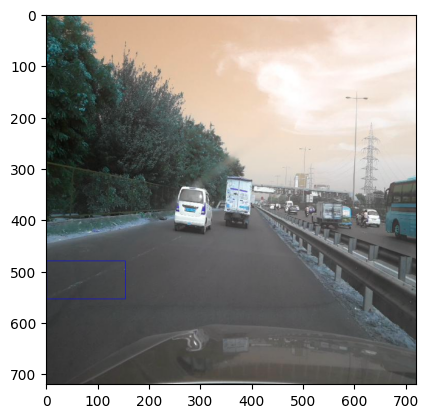

In [37]:
plot_bounding_box('dataset/train/images/012008.jpg')